In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Модель второго уровня
from lightgbm import LGBMClassifier

from pathlib import Path

# Написанные нами функции
from metrics import precision_at_k, calc_all_precision, calc_precision
from utils import prefilter_items, print_stats_data, get_hots_users
from recommenders import MainRecommender

In [2]:
DATA_PATH = Path('')
data = pd.read_csv(DATA_PATH / 'retail_train.csv')
item_features = pd.read_csv(DATA_PATH / 'product.csv')
user_features = pd.read_csv(DATA_PATH / 'hh_demographic.csv')
retail_test = pd.read_csv(DATA_PATH / 'retail_test1.csv')

In [3]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [4]:
item_features.head()

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [5]:
user_features.head()

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


Оценим плотность покупок в недельной агрегации, чтобы понять, были ли какие-нибудь периоды, которые стоит рассматривать отдельно:

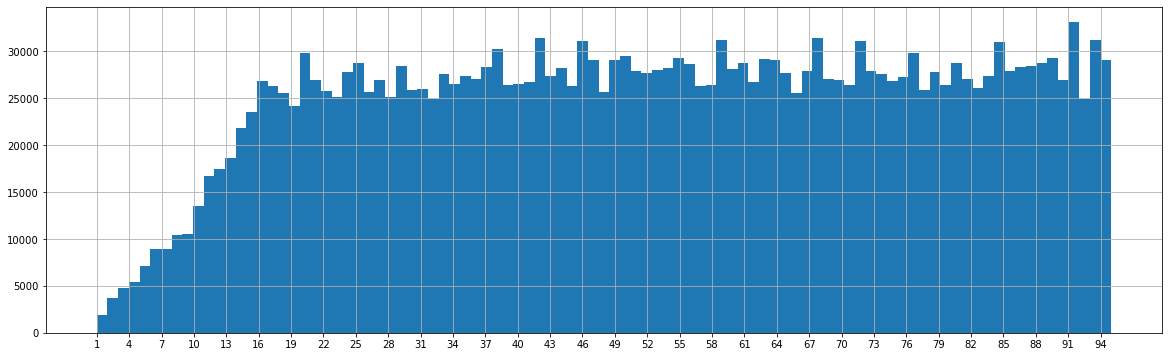

In [6]:
plt.figure(figsize=(20, 6))
plt.hist(data.week_no, bins=data.week_no.value_counts().shape[0])
plt.grid()
plt.xticks(np.arange(1, data.week_no.value_counts().shape[0], 3))
plt.show()

Распределние получается достаточно равномерное, поэтому выделять часть датасета на отдельный анализ не имеет смысла.

------

Подготовим обучающие и тестовые выборки и оставим только "горячих" пользователей:

In [7]:
train_df = data.copy()
test_df = retail_test.copy()

print(print_stats_data(train_df, 'Train df'))
print('------------')
print(print_stats_data(test_df, 'Test df'))

Train df
Shape: (2396804, 12) Users: 2499 Items: 89051
None
------------
Test df
Shape: (88734, 12) Users: 1885 Items: 20497
None


In [8]:
prep_train_df = prefilter_items(train_df, take_n_popular=2000)
test_df, prep_train_df = get_hots_users(test_df, prep_train_df)

print(print_stats_data(prep_train_df, 'Train df'))
print('------------')
print(print_stats_data(test_df, 'Test df'))

Train df
Shape: (1531097, 13) Users: 1884 Items: 2001
None
------------
Test df
Shape: (88724, 12) Users: 1884 Items: 20496
None


In [9]:
results = test_df.groupby('user_id')['item_id'].unique().reset_index()
results.columns = ['user_id', 'actual']
results.head()

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."
2,3,"[827683, 908531, 989069, 1071377, 1080155, 109..."
3,6,"[956902, 960791, 1037863, 1119051, 1137688, 84..."
4,7,"[847270, 855557, 859987, 863407, 895454, 90663..."


In [10]:
def results_clean():
    columns = [clm for clm in results.columns if clm not in ['user_id', 'actual']]
    results.drop(columns=columns, inplace=True)

Протестируем различные варианты бейзлайнов и определим, что можно использовать для дальнейшей максимазиации метрики:

In [86]:
model = MainRecommender(prep_train_df, agg_f='count')

results['own'] = results.user_id.apply(lambda row: model.get_own_recommendations(row, N=5))
results['als'] = results.user_id.apply(lambda row: model.get_als_recommendations(row, N=5))
results['sim_items'] = results.user_id.apply(lambda row: model.get_similar_items_recommendation(row, N=5))
results['sim_users'] = results.user_id.apply(lambda row: model.get_similar_users_recommendation(row, N=5))

sorted(calc_all_precision(results, 5), key=lambda x: x[1], reverse=True)

[('own', 0.20583864118895756),
 ('als', 0.09044585987261136),
 ('sim_items', 0.06496815286624254),
 ('sim_users', 0.020594479830148615)]

С достаточно большим отрывом рекомендация собственных покупок лидирует по сравнению с остальными алгоритмами и подходами, поэтому предлагается развивать именно ее.

*P.S. Так как не было выдвинуто никаких ограничений по бизнес результату, то можно выбрать рекомендацию собственных покупок, однако на практике вряд ли только такой подход будет полезен, т.к. пользователь и так покупал товар, который ему будут рекомендовать (и без рекомендаций скорее всего будет его покупать). Можно лишь иногда напоминать ему о том, что он еще есть в магазине, но не полностью составлять рекомендации из них.*

-------

Можно попробовать улучшить метрику путем замены агрегационной функции и дальнейших ее преобразований:

In [87]:
results_clean()

model = MainRecommender(prep_train_df, agg_f='count', only_own_rec=True)
results['own_cnt'] = results.user_id.apply(lambda row: model.get_own_recommendations(row, N=5))

model = MainRecommender(prep_train_df, only_own_rec=True)
results['own_sum'] = results.user_id.apply(lambda row: model.get_own_recommendations(row, N=5))

sorted(calc_all_precision(results, 5), key=lambda x: x[1], reverse=True)

[('own_cnt', 0.20583864118895756), ('own_sum', 0.19819532908704693)]

Как видно, сам по себе переход на сумму ничего хорошего не дал, однако он открывает возможность к некоторым новым подходам:

* логарифмирование количества покупок для устранения сильного влияния больших единичных партий
* учет количества покупок пользователей и их давности (ввод уменьшающего коэффициента, зависящего от давности совершенной транзакции)

Реализуем первый подход:

In [88]:
model = MainRecommender(prep_train_df, only_own_rec=True, log_quantity=True)
results['own_log_sum'] = results.user_id.apply(lambda row: model.get_own_recommendations(row, N=5))

sorted(calc_all_precision(results, 5), key=lambda x: x[1], reverse=True)

[('own_cnt', 0.20583864118895756),
 ('own_sum', 0.19819532908704693),
 ('own_log_sum', 0.13906581740976548)]

Логарифмирование суммы покупок не привело к улучшению метрики, поэтому оптимизацией в этом направлении скорее всего заниматься не стоит.

Проверим второй подход, причем пробежим по разным корректирующим коэффициентам для:

In [93]:
%%time

results_clean()

score_dict = dict()

for koef in range(10, 101, 10):
    prep_train_df = prefilter_items(train_df, take_n_popular=2000)
    test_df, prep_train_df = get_hots_users(test_df, prep_train_df)
    prep_train_df.quantity = np.exp(-(data.week_no.max() - data.week_no) / koef) * prep_train_df.quantity
    model = MainRecommender(prep_train_df, weighting=True, only_own_rec=True)
    results['log_koef_if_' + str(var)] = results.user_id.apply(lambda row: model.get_own_recommendations(row, N=5))
    score = calc_precision(results, 5, 'log_koef_if_' + str(var))
    score_dict[koef] = score
    print(koef, score)


10 0.17961783439490236
20 0.19129511677282166
30 0.1971337579617813
40 0.2005307855626306
50 0.20467091295116568
60 0.20424628450105958
70 0.20424628450105964
80 0.2037154989384271
90 0.2036093418259005
100 0.2041401273885331
Wall time: 1min 47s


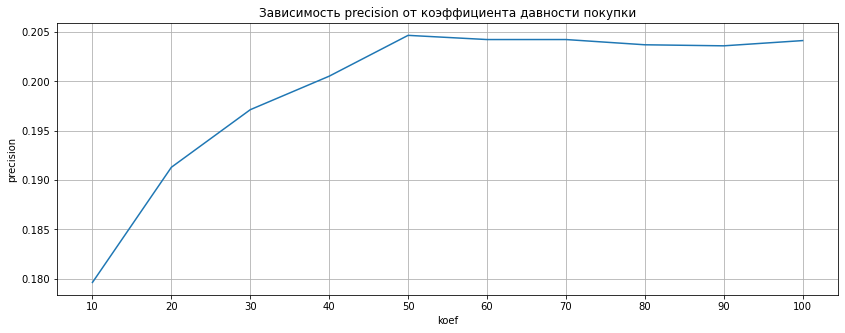

In [98]:
plt.figure(figsize=(14, 5))
plt.plot(score_dict.keys(), score_dict.values())
plt.title('Зависимость precision от коэффициента давности покупки')
plt.ylabel('precision')
plt.xlabel('koef')
plt.xticks(range(10, 101, 10))
plt.grid()
plt.show()

Результат получился лучше, чем с базовой суммой, но практически равен бейзлайну, поэтому можно попробовать их объединить и выбрать уже из полученного наилучший:

In [99]:
%%time

results_clean()

score_dict = dict()

for koef in range(10, 101, 10):
    prep_train_df = prefilter_items(train_df, take_n_popular=2000)
    test_df, prep_train_df = get_hots_users(test_df, prep_train_df)
    prep_train_df.quantity = np.exp(-(data.week_no.max() - data.week_no) / koef)
    model = MainRecommender(prep_train_df, weighting=True, only_own_rec=True)
    results['log_koef_if_' + str(var)] = results.user_id.apply(lambda row: model.get_own_recommendations(row, N=5))
    score = calc_precision(results, 5, 'log_koef_if_' + str(var))
    score_dict[koef] = score
    print(koef, score)

10 0.20159235668789613
20 0.20318471337579427
30 0.20403397027600612
40 0.20806794055201466
50 0.20870488322717395
60 0.20891719745222687
70 0.2095541401273861
80 0.21019108280254534
90 0.20881104033970038
100 0.2087048832271739
Wall time: 1min 43s


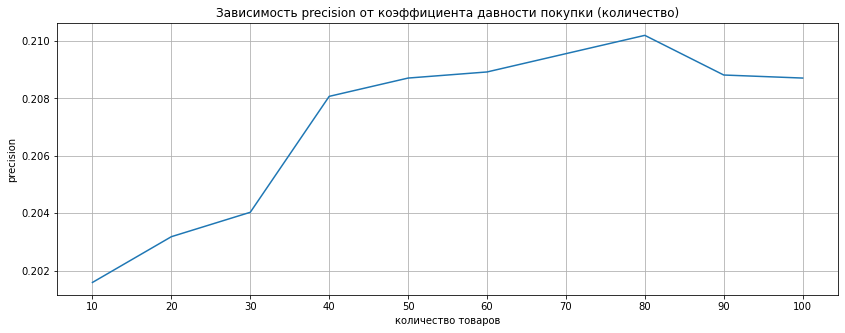

In [101]:
plt.figure(figsize=(14, 5))
plt.plot(score_dict.keys(), score_dict.values())
plt.title('Зависимость precision от коэффициента давности покупки (количество)')
plt.ylabel('precision')
plt.xlabel('количество товаров')
plt.xticks(range(10, 101, 10))
plt.grid()
plt.show()

Метрика действительно улучшилась. И что важно - она теперь превышает бейзлайн (**0.20584**) в точке максимума (**0.21019**).

Далее выберем оптимальное количество по пулу рекомендуемых товаров:

In [111]:
%%time

results_clean()

score_dict = dict()

for item_count in range(500, 6001, 500):
    prep_train_df = prefilter_items(train_df, take_n_popular=item_count)
    test_df, prep_train_df = get_hots_users(test_df, prep_train_df)
    prep_train_df.quantity = np.exp(-(data.week_no.max() - data.week_no) / 80)
    model = MainRecommender(prep_train_df, weighting=True, only_own_rec=True)
    results['log_koef_if_' + str(var)] = results.user_id.apply(lambda row: model.get_own_recommendations(row, N=5))
    score = calc_precision(results, 5, 'log_koef_if_' + str(var))
    score_dict[item_count] = score
    print(item_count, score)

500 0.2553078556263249
1000 0.22887473460721652
1500 0.21868365180466884
2000 0.21019108280254534
2500 0.2044585987261125
3000 0.19755838641188742
3500 0.1918259023354544
4000 0.18874734607218477
4500 0.18535031847133573
5000 0.18046709129511493
5500 0.17547770700636764
6000 0.17091295116772634
Wall time: 2min 29s


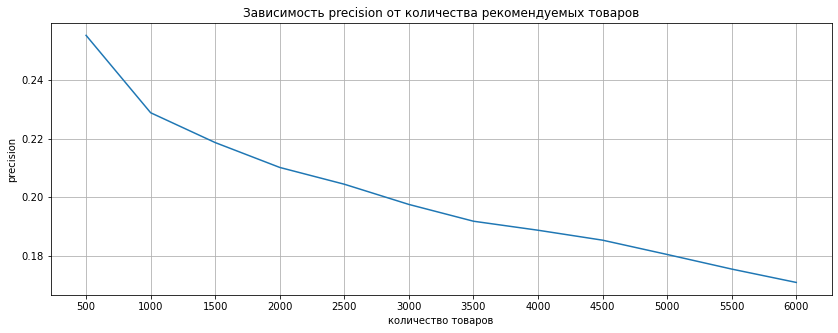

In [113]:
plt.figure(figsize=(14, 5))
plt.plot(score_dict.keys(), score_dict.values())
plt.title('Зависимость precision от количества рекомендуемых товаров')
plt.ylabel('precision')
plt.xlabel('количество товаров')
plt.xticks(range(500, 6001, 500))
plt.grid()
plt.show()

Видна четкая тенденция на то, что чем больший ассортимент имеется для покупки (дял комендаций), тем меньше будет вероятность рекомендовать будущую покупку или угадать предпочтения пользователя. Что и логично. Поэтому для максимизации precision можно было бы выбрать наиболее маленькое значение потенциально рекомендуемых товаров, но сейчас огранчиимся хотя бы 1.5 тыс., чтобы потьенциально от модели была какая-то польза.

------

Таким образом итоговая метрика на тестовом сете в `retail_test1.csv` будет равна **0.21019**, однако при необхоидимости ее можно повысить намного больше, ослабив или убрав некоторые критерии фильтрации товаров. Таким образом удавалось повысить ее в рамках не описанных здесь экспериментов до ~0.33, но такая модель на практике скорее будет работать намного хуже тех, которые описаны выше.